In [1]:
import json
from datasets import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import random
import time
import matplotlib.pyplot as plt
from validator import Validator
import csv 

/home/re2230/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # Replace 1 with the GPU index you want

print(torch.cuda.get_device_name(0))  # This will now refer to GPU 1 as "GPU 0" in the notebook context
print(torch.cuda.is_available())

print("Device count:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))


NVIDIA A100-SXM4-80GB
True
Device count: 1
Current GPU: 0
GPU name: NVIDIA A100-SXM4-80GB


In [5]:
# BOS = Beginning of Sequence → marks the start of a Modbus message.
# SEP = Separator → marks the boundary between the query and the response.
# EOS = End of Sequence → marks the end of the full sequence.
# PAD = Padding token → used to pad shorter sequences so they fit in a batch.
# VOCAB_SIZE = 260 → bytes (0–255) + 4 special tokens (256–259)

# Constants
BOS, SEP, EOS, PAD = 256, 257, 258, 259
VOCAB_SIZE = 260

# Load and preprocess dataset
#hexadecimal string into a list of byte values
def hex_to_bytes(hex_str):
    # 2-character group is treated as a hex byte and converted to decimal
    return [int(hex_str[i:i+2], 16) for i in range(0, len(hex_str), 2)]

# def preprocess(example):
#     q = hex_to_bytes(example["query"])
#     r = hex_to_bytes(example["response"])
#     return {
#         "input_ids": [BOS] + q + [SEP] + r + [EOS]
#     }

def preprocess(example):
    q = hex_to_bytes(example["query"])
    r = hex_to_bytes(example["response"])
    
    input_ids = [BOS] + q + [SEP] + r + [EOS]
    
    # Build labels: ignore all tokens before the response
    sep_index = len(q) + 1  # BOS + query
    label_start = sep_index + 1
    labels = [-100] * label_start + input_ids[label_start:]

    return {
        "input_ids": input_ids,
        "labels": labels
    }


with open("modbus_dataset.jsonl", "r") as f:
    train_data = [json.loads(line) for line in f]

with open("modbus_dataset_test.jsonl", "r") as f:
    test_data = [json.loads(line) for line in f]

with open("modbus_dataset_validation.jsonl", "r") as f:
    validation_data = [json.loads(line) for line in f]

#turns a list of dictionaries into a Dataset object
train_dataset = Dataset.from_list([preprocess(d) for d in train_data])
test_dataset = Dataset.from_list([preprocess(d) for d in test_data])
val_dataset = Dataset.from_list([preprocess(d) for d in validation_data])

In [ ]:
# Model
class DecoderOnlyTransformer(nn.Module):
    # vocab_size = how many distinct tokens we can embed
    #d_model =  size of each embedding vector.
    #n_heads: number of attention heads. Helps the model focus on different parts of the sequence simultaneously.
    # n_layers: number of transformer layers stacked
    def __init__(self, vocab_size, d_model, n_heads, n_layers, dropout=0.1):
        super().__init__()
        #Converts each token ID into a dense vector of dimension d_model.
        self.token_emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pos_emb = nn.Embedding(512, d_model)
        # Even though we call it "encoder layer", apply causal masks later to make it autoregressive like a decoder.
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_model*4, dropout=dropout, batch_first=True
            ) for _ in range(n_layers)
        ]) # dim_feedforward = Size of the hidden layer inside the feed-forward network of the Transformer.
        self.norm = nn.LayerNorm(d_model)
        #Maps the output of the model (of shape [batch, seq_len, d_model]) to logits over the vocabulary.
        self.output = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        B, T = x.size() # B is the batch size, T is the sequence length (number of tokens in each input)
        positions = torch.arange(0, T, device=x.device).unsqueeze(0).expand(B, T)
        x = self.token_emb(x) + self.pos_emb(positions)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(x.device) # Ensures the model can only attend to current and past tokens, not future ones
        for layer in self.layers:
            x = layer(x, src_mask=tgt_mask)  # Applies each encoder layer sequentially
        x = self.norm(x)
        return self.output(x) # Projects the final hidden states back to vocabulary space: for each token position, the model predicts a probability distribution over the 260 tokens (0–259)


# Collate
# def collate(batch):
#     #Ensures all sequences are of shape [max_len], Required because Transformers need all sequences in a batch to be the same length
#     max_len = max(len(x["input_ids"]) for x in batch)
#     padded = [x["input_ids"] + [PAD] * (max_len - len(x["input_ids"])) for x in batch]
#     return {
#         "input_ids": torch.tensor(padded, dtype=torch.long),
#         "labels": torch.tensor(padded, dtype=torch.long)
#     }

def collate(batch):
    max_len = max(len(x["input_ids"]) for x in batch)
    padded_inputs = [x["input_ids"] + [PAD] * (max_len - len(x["input_ids"])) for x in batch]
    padded_labels = [x["labels"] + [-100] * (max_len - len(x["labels"])) for x in batch]
    
    return {
        "input_ids": torch.tensor(padded_inputs, dtype=torch.long),
        "labels": torch.tensor(padded_labels, dtype=torch.long)
    }


# Sample hyperparameters
def sample_hparams():
    return {
        "d_model": random.choice([128, 256]),
        "n_heads": random.choice([2, 4]),
        "n_layers": random.choice([2, 4]),
        "lr": random.choice([1e-4, 5e-4]),
        "batch_size": random.choice([8, 16]),
        "epochs": 250
    }

# Generate
def generate(model, input_seq, max_len=32):
    model.eval()
    with torch.no_grad():
        #Copies the input sequence so the original is not modified
        seq = input_seq[:]
        for _ in range(max_len):
            x = torch.tensor([seq], dtype=torch.long).to(next(model.parameters()).device)
            logits = model(x)
            next_token = logits[0, -1].argmax().item()
            if next_token == EOS:
                break
            seq.append(next_token)
        return seq

# Evaluate
def evaluate(model, dataset, device, print_limit=5):
    correct, total, shown = 0, 0, 0
    for item in dataset:
        tokens = item["input_ids"]
        sep_idx = tokens.index(SEP)
        query = tokens[:sep_idx+1]
        true = tokens[sep_idx+1:-1]

        pred = generate(model, query)
        pred = pred[pred.index(SEP)+1:]
        if EOS in pred:
            pred = pred[:pred.index(EOS)]

        matches = sum(1 for i in range(min(len(true), len(pred))) if true[i] == pred[i])
        correct += matches
        total += len(true)

        if shown < print_limit:
            def tohex(x): return ''.join(f"{b:02x}" for b in x)
            print("\nQuery:             ", tohex(query[1:-1]))
            print("True Response:     ", tohex(true))
            print("Predicted Response:", tohex(pred))
            shown += 1
    acc = 100 * correct / total
    print(f"\n✅ Byte-Level Accuracy: {acc:.2f}%")
    return acc


def evaluate_with_validator(model, dataset, device, print_limit=5, end_address=3, save_errors=True, error_log_file="validator_failures.csv"):
    exact_matches = 0
    total_samples = 0
    shown = 0
    failed_validations = 0
    failed_cases = []

    is_byte_level = VOCAB_SIZE > 100
    id_to_char = {i: c for i, c in enumerate("0123456789abcdef")}

    for item in dataset:
        tokens = item["input_ids"]
        sep_idx = tokens.index(SEP)
        query = tokens[:sep_idx+1]
        true = tokens[sep_idx+1:-1]

        pred = generate(model, query)
        pred = pred[pred.index(SEP)+1:]
        if EOS in pred:
            pred = pred[:pred.index(EOS)]

        if is_byte_level:
            q_hex = ''.join(f"{b:02x}" for b in query[1:-1])
            r_true_hex = ''.join(f"{b:02x}" for b in true)
            r_pred_hex = ''.join(f"{b:02x}" for b in pred)
        else:
            q_hex = ''.join(id_to_char[b] for b in query[1:-1])
            r_true_hex = ''.join(id_to_char[b] for b in true)
            r_pred_hex = ''.join(id_to_char[b] for b in pred)

        if pred == true:
            exact_matches += 1
        total_samples += 1

        try:
            val = Validator(q_hex, r_pred_hex, r_true_hex, end_address)
            val.check_header_ids()
            val.check_payload()
        except Exception as e:
            failed_validations += 1
            failed_cases.append({
                "query": q_hex,
                "expected_response": r_true_hex,
                "predicted_response": r_pred_hex,
                "error": str(e)
            })
            if shown < print_limit:
                print(f"\n❌ Validator Error: {e}")

        if shown < print_limit:
            print("\nQuery:             ", q_hex)
            print("True Response:     ", r_true_hex)
            print("Predicted Response:", r_pred_hex)
            shown += 1

    acc = 100 * exact_matches / total_samples if total_samples else 0
    val_rate = 100 * (total_samples - failed_validations) / total_samples if total_samples else 0

    print(f"\n✅ Exact Match Accuracy: {acc:.2f}%")
    print(f"🛡️  Validator Pass Rate: {val_rate:.2f}%")

    # Optional: save failed cases to CSV
    if save_errors and failed_cases:
        with open(error_log_file, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=["query", "expected_response", "predicted_response", "error"])
            writer.writeheader()
            writer.writerows(failed_cases)
        print(f"📝 Saved {len(failed_cases)} failed validations to {error_log_file}")

    return {
        "exact_match": acc,
        "validator_pass": val_rate,
        "total_samples": total_samples,
        "failed": failed_cases
    }

def evaluate_exact(model, dataset, device, print_limit=5):
    exact_matches = 0
    total_samples = 0
    shown = 0

    for item in dataset:
        tokens = item["input_ids"]
        sep_idx = tokens.index(SEP)
        query = tokens[:sep_idx+1]
        true = tokens[sep_idx+1:-1]  # remove EOS

        pred = generate(model, query)
        pred = pred[pred.index(SEP)+1:]
        if EOS in pred:
            pred = pred[:pred.index(EOS)]

        # Exact match check
        if pred == true:
            exact_matches += 1
        total_samples += 1

        # Optional print
        if shown < print_limit:
            def tohex(x): return ''.join(f"{b:02x}" for b in x)
            print("\nQuery:             ", tohex(query[1:-1]))
            print("True Response:     ", tohex(true))
            print("Predicted Response:", tohex(pred))
            shown += 1

    accuracy = 100 * exact_matches / total_samples if total_samples > 0 else 0
    print(f"\n✅ Exact Match Accuracy: {accuracy:.2f}%")
    return accuracy

# Training
def train_transformer(model, dataloader, hparams, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
    # loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    loss_history=[]

    for epoch in range(hparams["epochs"]):
        model.train()
        total_loss = 0
        for batch in dataloader:
            x = batch["input_ids"].to(device)
            y = batch["labels"].to(device)
            # 🛑 Check label range
            bad_labels = y[(y != -100) & ((y < 0) | (y >= VOCAB_SIZE))]
            if bad_labels.numel() > 0:
                print("❌ Invalid label values:", bad_labels)
                raise ValueError("Some labels are outside the VOCAB_SIZE range")
            
            logits = model(x)[:, :-1, :]
            targets = y[:, 1:]

            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return loss_history



def train_transformer_val(model, train_dataloader, val_dataloader, hparams, device):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
    # loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    
    train_loss_history = []
    val_loss_history = []

    for epoch in range(hparams["epochs"]):
        # === Training ===
        model.train()
        total_train_loss = 0
        for batch in train_dataloader:
            x = batch["input_ids"].to(device)
            y = batch["labels"].to(device)
            # Check for label issues
            # bad_labels = y[(y != -100) & ((y < 0) | (y >= VOCAB_SIZE))]
            # if bad_labels.numel() > 0:
            #     print("❌ Invalid label values:", bad_labels)
            #     raise ValueError("Some labels are outside the VOCAB_SIZE range")
            logits = model(x)[:, :-1, :]
            targets = y[:, 1:]
            loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_history.append(avg_train_loss)

        # === Validation ===
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for batch in val_dataloader:
                x = batch["input_ids"].to(device)
                y = batch["labels"].to(device)
                logits = model(x)[:, :-1, :]
                targets = y[:, 1:]

                val_loss = loss_fn(logits.reshape(-1, VOCAB_SIZE), targets.reshape(-1))
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        val_loss_history.append(avg_val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_loss_history, val_loss_history

# Generate
# def generate(model, input_seq, max_len=32):
#     model.eval()
#     with torch.no_grad():
#         #Copies the input sequence so the original is not modified
#         seq = input_seq[:] #the query part is the only section passed
#         for _ in range(max_len):
#             x = torch.tensor([seq], dtype=torch.long).to(next(model.parameters()).device) # the result has shape [1, sequence_length], representing a batch size of 1.
#             logits = model(x)
#             next_token = logits[0, -1].argmax().item()
#             if next_token == EOS:
#                 break
#             seq.append(next_token)
#         return seq


# def train_transformer_val(model, train_loader, val_loader, hparams, device):
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
#     loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)  # or your loss of choice

#     train_losses = []
#     val_losses = []

#     for epoch in range(hparams["epochs"]):
#         model.train()
#         total_train_loss = 0

#         for batch in train_loader:
#             input_ids = batch["input_ids"].to(device)
#             target = input_ids[:, 1:]  # predict next token
#             input_ids = input_ids[:, :-1]  # feed everything except last

#             output = model(input_ids)
#             loss = loss_fn(output.view(-1, output.size(-1)), target.contiguous().view(-1))

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_train_loss += loss.item()

#         avg_train_loss = total_train_loss / len(train_loader)
#         train_losses.append(avg_train_loss)

#         # 🔍 Validation
#         model.eval()
#         total_val_loss = 0

#         with torch.no_grad():
#             for batch in val_loader:
#                 input_ids = batch["input_ids"].to(device)
#                 target = input_ids[:, 1:]
#                 input_ids = input_ids[:, :-1]

#                 output = model(input_ids)
#                 loss = loss_fn(output.view(-1, output.size(-1)), target.contiguous().view(-1))
#                 total_val_loss += loss.item()

#         avg_val_loss = total_val_loss / len(val_loader)
#         val_losses.append(avg_val_loss)

#         print(f"📉 Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
#     return train_losses, val_losses



In [8]:

def best_hyper():
    return {
        "d_model": 128,
        "n_heads": 4,
        "n_layers": 4,
        "lr": 5e-4,
        "batch_size": 16,
        "epochs": 50
    }

def try_million_parameters():
    return{
    "d_model": 256,        # embedding size
    "n_heads": 8,          # must divide d_model evenly
    "n_layers": 6,         # number of Transformer blocks
    "batch_size": 16,
    "epochs": 100
}

In [4]:
# #Train with Validation dataset
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# hparams = best_hyper()
# model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])

# # train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
# # val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)

# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=hparams["lr"])
# loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
# # loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
# loss_history=[]
# model.train()
# total_loss = 0

# dataloader= DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)

# for batch in dataloader:
    
#     input_ids = batch["input_ids"].to(device)
#     labels = batch["labels"].to(device)

#     for i in range(input_ids.size(0)):  # loop through batch dimension
#         x = input_ids[i].unsqueeze(0)  # shape [1, seq_len]
#         y = labels[i].unsqueeze(0)

#         print("🔹 Input IDs:", x)
#         print("🔸 Labels:", y)

#         logits = model(x)[:, :-1, :]
#         print("🔺 Logits:", logits)
#         targets = y[:, 1:]
#         print("🎯 Targets:", targets)

#         # Optional: pause or break after one item
#         input("Press Enter to continue...\n")



In [9]:
#Train with Validation dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = best_hyper()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])


train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)
train_loss, val_loss = train_transformer_val(model, train_loader, val_loader, hparams, device)


plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

print ("Bit by Bit accuracy")
evaluate(model, test_dataset, device)
print ("Exact Matching")
evaluate_exact(model, test_dataset, device)
print ("Validator Accuracy")





/pytorch/aten/src/ATen/native/cuda/Loss.cu:242: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:242: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:242: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:242: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:242: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/src/ATen/native/cuda/Loss.cu:242: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
/pytorch/aten/sr

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
results = evaluate_with_validator(
    model=model,
    dataset=val_dataset,
    device=device,
    print_limit=3,
    end_address=39,
    save_errors=True,
    error_log_file="validator_failures_vocab260.csv"
)


Query:              0000000000060001fffd0001
True Response:      000000000003008102
Predicted Response: 000000000003008102

Query:              925500000006000300220002
True Response:      92550000000700030400000000
Predicted Response: 925500000007000304d00aed6c

Query:              8f1800000006000300250002
True Response:      8f180000000700030400000000
Predicted Response: 8f1800000007000304ffffffff



✅ Exact Match Accuracy: 82.72%
🛡️  Validator Pass Rate: 99.46%
📝 Saved 7 failed validations to validator_failures_vocab260.csv


In [12]:
# Run BEST CONFIGURATION
    #Best Combination found
# d_model          128.000000
# n_heads            4.000000
# n_layers           4.000000
# lr                 0.000500
# batch_size        16.000000
# epochs           500.000000
# byte_accuracy     96.566265
# Name: 39, dtype: float64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = best_hyper()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)

loss_history= train_transformer(model, train_loader, hparams, device)

# plt.figure(figsize=(8,5))
# plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
# plt.title(f"Training Loss per Epoch. Best Config found")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.show()

evaluate(model, test_dataset, device)
print ("Exact Matching")
evaluate_exact(model, test_dataset, device)



Epoch 1, Loss: 1.1476
Epoch 2, Loss: 0.6865
Epoch 3, Loss: 0.5470
Epoch 4, Loss: 0.4365
Epoch 5, Loss: 0.3770
Epoch 6, Loss: 0.3491
Epoch 7, Loss: 0.3324
Epoch 8, Loss: 0.3196
Epoch 9, Loss: 0.3114
Epoch 10, Loss: 0.3051
Epoch 11, Loss: 0.2996
Epoch 12, Loss: 0.2948
Epoch 13, Loss: 0.2951
Epoch 14, Loss: 0.2896
Epoch 15, Loss: 0.2858
Epoch 16, Loss: 0.2845
Epoch 17, Loss: 0.2825
Epoch 18, Loss: 0.2808
Epoch 19, Loss: 0.2772
Epoch 20, Loss: 0.2760
Epoch 21, Loss: 0.2754
Epoch 22, Loss: 0.2735
Epoch 23, Loss: 0.2720
Epoch 24, Loss: 0.2693
Epoch 25, Loss: 0.2691
Epoch 26, Loss: 0.2674
Epoch 27, Loss: 0.2658
Epoch 28, Loss: 0.2651
Epoch 29, Loss: 0.2650
Epoch 30, Loss: 0.2639
Epoch 31, Loss: 0.2617
Epoch 32, Loss: 0.2590
Epoch 33, Loss: 0.2586
Epoch 34, Loss: 0.2577
Epoch 35, Loss: 0.2580
Epoch 36, Loss: 0.2559
Epoch 37, Loss: 0.2546
Epoch 38, Loss: 0.2536
Epoch 39, Loss: 0.2508
Epoch 40, Loss: 0.2522
Epoch 41, Loss: 0.2501
Epoch 42, Loss: 0.2503
Epoch 43, Loss: 0.2450
Epoch 44, Loss: 0.24

86.25

In [10]:
#Try Model with much bigger size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = try_million_parameters()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)

loss_history= train_transformer(model, train_loader, hparams, device)

evaluate(model, test_dataset, device)
print ("Exact Matching")
evaluate_exact(model, test_dataset, device)

#Counter of Parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🔢 Total Trainable Parameters: {num_params:,}")



KeyError: 'lr'

In [45]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [13]:
results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=3,
    end_address=39,
    save_errors=True,
    error_log_file="validator_failures_vocab260.csv"
)



Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

❌ Validator Error: payload: ['05', '00', '00', '00', '00'], expected: ['05', '00', '09', '00', '00']

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb00000006000500000000



✅ Exact Match Accuracy: 86.25%
🛡️  Validator Pass Rate: 98.12%
📝 Saved 3 failed validations to validator_failures_vocab260.csv


In [ ]:
#Number of Trainable Parameters Estimation 
# Params ≈ Embeddings + PosEmbed + (n_layers × LayerParams) + FinalLayer
#Layer Parameter:
# Multi-head attention (Q, K, V, out): 4 × d_model × d_model
# LayerNorms: 2 × d_model
# Feedforward (FFN): usually d_model × 4 × d_model → 2 × d_model × d_ff

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = best_hyper()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {num_params:,}")

Total Trainable Parameters: 925,700


In [10]:
#Experiment No Conversion Hexadecimal Bytes to Decima

# Constants
BOS, SEP, EOS, PAD = 16, 17, 18, 19
VOCAB_SIZE = 20  # 16 hex chars + 4 special tokens

# Load and preprocess dataset
# def preprocess_hex_chars(example):
#     # Keep query and response as hexadecimal characters
#     q = list(example["query"])    # e.g. "0103020001" → ['0','1','0','3',...]
#     r = list(example["response"])
#     # Convert hex chars to token ids (e.g. '0'→0, 'f'→15 or 'f'→255 depending on vocab)
#     char_to_id = {c: i for i, c in enumerate("0123456789abcdef")}
#     q_ids = [char_to_id[c.lower()] for c in q]
#     r_ids = [char_to_id[c.lower()] for c in r]

#     return {
#         "input_ids": [BOS] + q_ids + [SEP] + r_ids + [EOS]
#     }

def preprocess_hex_chars(example):
    char_to_id = {c: i for i, c in enumerate("0123456789abcdef")}

    q = [char_to_id[c.lower()] for c in example["query"]]
    r = [char_to_id[c.lower()] for c in example["response"]]

    input_ids = [BOS] + q + [SEP] + r + [EOS]

    # Create labels: PAD for query + SEP, actual IDs for response + EOS
    labels = [PAD] * (len(q) + 2) + r + [EOS]  # PAD for BOS + query + SEP

    return {
        "input_ids": input_ids,
        "labels": labels
    }


with open("modbus_dataset.jsonl", "r") as f:
    train_data = [json.loads(line) for line in f]

with open("modbus_dataset_test.jsonl", "r") as f:
    test_data = [json.loads(line) for line in f]

with open("modbus_dataset_validation.jsonl", "r") as f:
    validation_data = [json.loads(line) for line in f]

#turns a list of dictionaries into a Dataset object
train_dataset = Dataset.from_list([preprocess_hex_chars(d) for d in train_data])
test_dataset = Dataset.from_list([preprocess_hex_chars(d) for d in test_data])
val_dataset = Dataset.from_list([preprocess_hex_chars(d) for d in validation_data])

def best_hyper():
    return {
        "d_model": 128,
        "n_heads": 4,
        "n_layers": 4,
        "lr": 5e-4,
        "batch_size": 16,
        "epochs": 100
    }

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = best_hyper()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])
train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
loss_history= train_transformer(model, train_loader, hparams, device)

#Training Loss Plot
# plt.figure(figsize=(8,5))
# plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
# plt.title(f"Training Loss per Epoch. Trial")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.grid(True)
# plt.show()

#Counter of Parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"🔢 Total Trainable Parameters: {num_params:,}")

#Evaluation of Model
evaluate(model, test_dataset, device)
evaluate_exact(model, test_dataset, device)



Epoch 1, Loss: 1.1886
Epoch 2, Loss: 0.6666
Epoch 3, Loss: 0.5355
Epoch 4, Loss: 0.4517
Epoch 5, Loss: 0.3805
Epoch 6, Loss: 0.3441
Epoch 7, Loss: 0.3259
Epoch 8, Loss: 0.3185
Epoch 9, Loss: 0.3079
Epoch 10, Loss: 0.3020
Epoch 11, Loss: 0.2979
Epoch 12, Loss: 0.2938
Epoch 13, Loss: 0.2922
Epoch 14, Loss: 0.2876
Epoch 15, Loss: 0.2839
Epoch 16, Loss: 0.2825
Epoch 17, Loss: 0.2803
Epoch 18, Loss: 0.2797
Epoch 19, Loss: 0.2768
Epoch 20, Loss: 0.2756
Epoch 21, Loss: 0.2751
Epoch 22, Loss: 0.2729
Epoch 23, Loss: 0.2692
Epoch 24, Loss: 0.2695
Epoch 25, Loss: 0.2696
Epoch 26, Loss: 0.2656
Epoch 27, Loss: 0.2646
Epoch 28, Loss: 0.2641
Epoch 29, Loss: 0.2644
Epoch 30, Loss: 0.2615
Epoch 31, Loss: 0.2624
Epoch 32, Loss: 0.2596


KeyboardInterrupt: 

In [8]:
results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=5,              # Optional
    end_address=3,            # Adjust based on your data
    save_errors=True,
    error_log_file="validator_failures_vocab25.csv"
)



Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

❌ Validator Error: Should have thrown an exception since requested address: 9 exceeds: 3

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb0000000600050000ff00

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 061000000003009002

✅ Exact Match Accuracy: 85.00%
🛡️  Validator Pass Rate: 69.38%
📝 Saved 49 failed validations to validator_failures_vocab25.csv


📉 Epoch 1 | Train Loss: 1.1135 | Val Loss: 1.4952
📉 Epoch 2 | Train Loss: 0.6467 | Val Loss: 1.5185
📉 Epoch 3 | Train Loss: 0.5093 | Val Loss: 1.5405
📉 Epoch 4 | Train Loss: 0.4209 | Val Loss: 1.6147
📉 Epoch 5 | Train Loss: 0.3775 | Val Loss: 1.6851
📉 Epoch 6 | Train Loss: 0.3519 | Val Loss: 1.7361
📉 Epoch 7 | Train Loss: 0.3331 | Val Loss: 1.7844
📉 Epoch 8 | Train Loss: 0.3206 | Val Loss: 1.8387
📉 Epoch 9 | Train Loss: 0.3115 | Val Loss: 1.8317
📉 Epoch 10 | Train Loss: 0.3031 | Val Loss: 1.8567
📉 Epoch 11 | Train Loss: 0.2979 | Val Loss: 1.9095
📉 Epoch 12 | Train Loss: 0.2941 | Val Loss: 1.9271
📉 Epoch 13 | Train Loss: 0.2907 | Val Loss: 1.9333
📉 Epoch 14 | Train Loss: 0.2886 | Val Loss: 1.9650
📉 Epoch 15 | Train Loss: 0.2863 | Val Loss: 1.9814
📉 Epoch 16 | Train Loss: 0.2843 | Val Loss: 2.0458
📉 Epoch 17 | Train Loss: 0.2827 | Val Loss: 1.9390
📉 Epoch 18 | Train Loss: 0.2803 | Val Loss: 2.0892
📉 Epoch 19 | Train Loss: 0.2766 | Val Loss: 2.0458
📉 Epoch 20 | Train Loss: 0.2756 | Val Lo

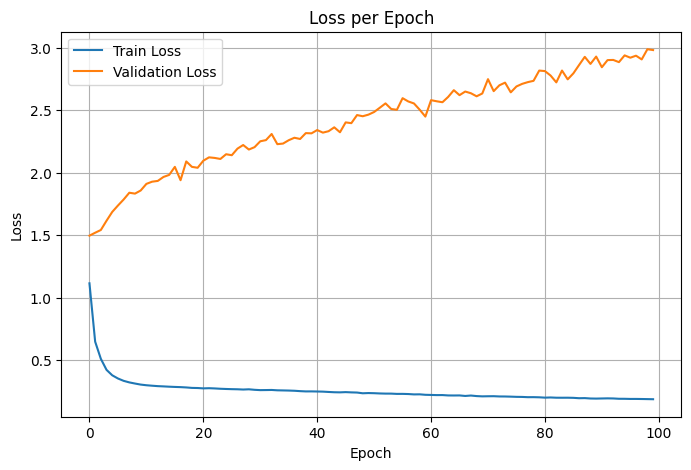

Bit by Bit accuracy

Query:              0002010d0000000000000006000000030f0f0f0d00000002
True Response:      0002010d0000000000000003000008030002
Predicted Response: 0002010d0000000000000003000008030002

Query:              0001020c0000000000000006000000050f0f0f0d0f0f0000
True Response:      0001020c0000000000000003000008050002
Predicted Response: 0001020c0000000000000003000008050002

Query:              00030e0b0000000000000006000000050000000900000000
True Response:      00030e0b0000000000000006000000050000000900000000
Predicted Response: 00030e0b0000000000000006000000050000000000000000

Query:              0004050d0000000000000006000000010f0f0f0e00000001
True Response:      0004050d0000000000000003000008010002
Predicted Response: 0004050d0000000000000003000008010002

Query:              00060100000000000000000d0000010000000208000000030006000000000f0f0f0f00000000
True Response:      000601000000000000000003000009000002
Predicted Response: 000601000000000000000003000009000002

✅ Byte-

In [11]:
#Train with Validation dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hparams = best_hyper()
model = DecoderOnlyTransformer(VOCAB_SIZE, hparams["d_model"], hparams["n_heads"], hparams["n_layers"])


train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=collate)
train_loss, val_loss = train_transformer_val(model, train_loader, val_loader, hparams, device)


plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

print ("Bit by Bit accuracy")
evaluate(model, test_dataset, device)
print ("Exact Matching")
evaluate_exact(model, test_dataset, device)
print ("Validator Accuracy")

results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=3,
    end_address=3,
    save_errors=True,
    error_log_file="validator_failures_vocab260.csv"
)



In [ ]:

#Searching for best configuration for experiment of no translation preprocessing

configs = [
    {"d_model": 128, "n_heads": 4, "n_layers": 4, "lr": 0.0005, "batch_size": 16, "epochs": 500},
    {"d_model": 128, "n_heads": 2, "n_layers": 4, "lr": 0.0001, "batch_size": 16, "epochs": 250},
    {"d_model": 128, "n_heads": 4, "n_layers": 8, "lr": 0.0005, "batch_size": 16, "epochs": 100},
    {"d_model": 128, "n_heads": 8, "n_layers": 2, "lr": 0.0005, "batch_size": 16, "epochs": 50},
    {"d_model": 256, "n_heads": 8, "n_layers": 4, "lr": 0.0005, "batch_size": 16, "epochs": 50},
    {"d_model": 256, "n_heads": 8, "n_layers": 8, "lr": 0.0001, "batch_size": 16, "epochs": 250},
    {"d_model": 256, "n_heads": 8, "n_layers": 8, "lr": 0.0001, "batch_size": 16, "epochs": 500},
    {"d_model": 128, "n_heads": 16, "n_layers": 8, "lr": 0.0005, "batch_size": 16, "epochs": 50},
    {"d_model": 128, "n_heads": 16, "n_layers": 4, "lr": 0.0005, "batch_size": 16, "epochs": 50},
    {"d_model": 256, "n_heads": 8, "n_layers": 4, "lr": 0.0001, "batch_size": 16, "epochs": 50},
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for idx, hparams in enumerate(configs):
    print(f"\n🔁 Testing Model {idx+1} with config: {hparams}")

    model = DecoderOnlyTransformer(
        vocab_size=VOCAB_SIZE,
        d_model=hparams["d_model"],
        n_heads=hparams["n_heads"],
        n_layers=hparams["n_layers"],
    ).to(device)

    train_loader = DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=collate)

    # Optional: Skip training if you've already trained these models
    train_transformer(model, train_loader, hparams, device)

    # Evaluation
    print("🎯 Byte-Level Accuracy:")
    evaluate(model, test_dataset, device)

    print("✅ Exact Match Accuracy:")
    evaluate_exact(model, test_dataset, device)

    print("Validator accuracy")
    results = evaluate_with_validator(
    model=model,
    dataset=test_dataset,
    device=device,
    print_limit=5,              # Optional
    end_address=255,            # Adjust based on your data
    save_errors=True,
    error_log_file="validator_failures_loop.csv"
     )




🔁 Trial 1/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 2.0, 'lr': 0.0001, 'batch_size': 16.0, 'epochs': 50.0}


Epoch 1, Loss: 3.6366
Epoch 2, Loss: 2.3613
Epoch 3, Loss: 1.8161
Epoch 4, Loss: 1.5614
Epoch 5, Loss: 1.4016
Epoch 6, Loss: 1.2865
Epoch 7, Loss: 1.1967
Epoch 8, Loss: 1.1329
Epoch 9, Loss: 1.0816
Epoch 10, Loss: 1.0439
Epoch 11, Loss: 1.0122
Epoch 12, Loss: 0.9833
Epoch 13, Loss: 0.9592
Epoch 14, Loss: 0.9387
Epoch 15, Loss: 0.9144
Epoch 16, Loss: 0.9040
Epoch 17, Loss: 0.8871
Epoch 18, Loss: 0.8771
Epoch 19, Loss: 0.8694
Epoch 20, Loss: 0.8590
Epoch 21, Loss: 0.8501
Epoch 22, Loss: 0.8436
Epoch 23, Loss: 0.8399
Epoch 24, Loss: 0.8312
Epoch 25, Loss: 0.8264
Epoch 26, Loss: 0.8216
Epoch 27, Loss: 0.8195
Epoch 28, Loss: 0.8116
Epoch 29, Loss: 0.8095
Epoch 30, Loss: 0.8062
Epoch 31, Loss: 0.7992
Epoch 32, Loss: 0.7934
Epoch 33, Loss: 0.7931
Epoch 34, Loss: 0.7907
Epoch 35, Loss: 0.7847
Epoch 36, Loss: 0.7850
Epoch 37, Loss: 0.7816
Epoch 38, Loss: 0.7758
Epoch 39, Loss: 0.7749
Epoch 40, Loss: 0.7724
Epoch 41, Loss: 0.7684
Epoch 42, Loss: 0.7664
Epoch 43, Loss: 0.7648
Epoch 44, Loss: 0.76

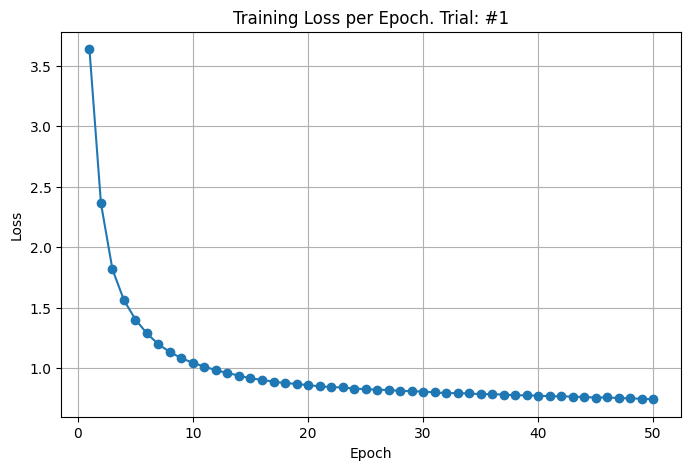


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 02f900000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 010b00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03ff0000000600050027ff00

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 043e00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 063800000003009002

✅ Byte-Level Accuracy: 85.42%
🧠 Byte-level Accuracy: 85.42%

🔁 Trial 2/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 2.0, 'lr': 0.0001, 'batch_size': 16.0, 'epochs': 100.0}
Epoch 1, Loss: 3.6113
Epoch 2, Loss: 2.3519
Epoch 3, Loss: 1.8381
Epoch 4, Loss: 1.5672
Epoch 5, Loss: 1.4014
Epoch 6, Loss: 1.2865
Epoch 7, Loss: 1.1975
Epoch 8, Lo

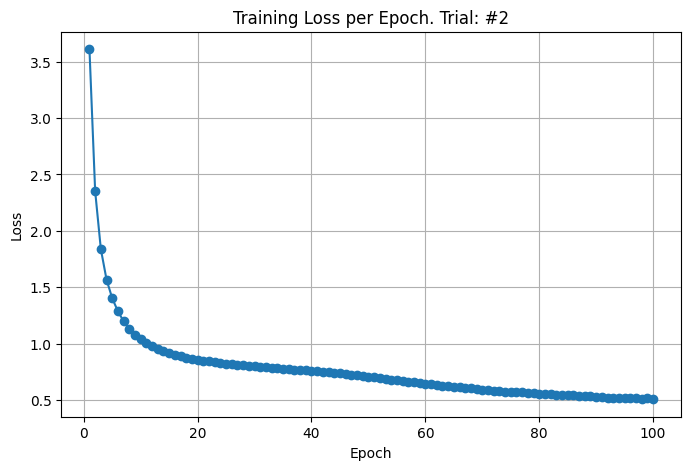


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb00000006000500270000

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 061000000003009002

✅ Byte-Level Accuracy: 95.36%
🧠 Byte-level Accuracy: 95.36%

🔁 Trial 3/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 2.0, 'lr': 0.0001, 'batch_size': 16.0, 'epochs': 250.0}
Epoch 1, Loss: 3.6619
Epoch 2, Loss: 2.3828
Epoch 3, Loss: 1.8486
Epoch 4, Loss: 1.5785
Epoch 5, Loss: 1.4126
Epoch 6, Loss: 1.2940
Epoch 7, Loss: 1.1976
Epoch 8, Lo

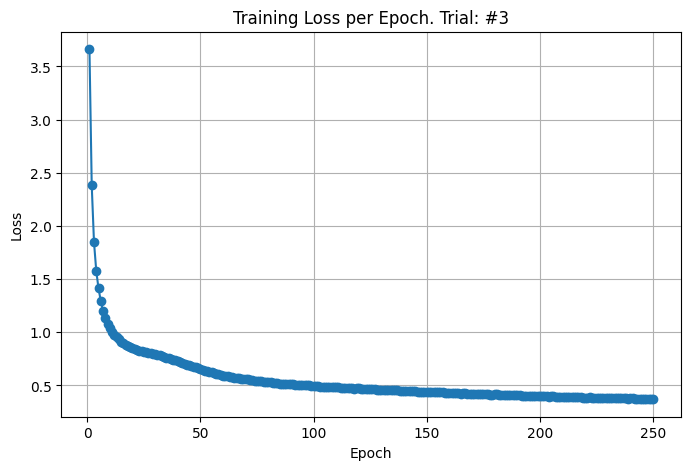


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb00000006000500270000

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 060000000003009002

✅ Byte-Level Accuracy: 95.66%
🧠 Byte-level Accuracy: 95.66%

🔁 Trial 4/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 2.0, 'lr': 0.0001, 'batch_size': 16.0, 'epochs': 500.0}
Epoch 1, Loss: 3.5902
Epoch 2, Loss: 2.2992
Epoch 3, Loss: 1.8390
Epoch 4, Loss: 1.5896
Epoch 5, Loss: 1.4229
Epoch 6, Loss: 1.3019
Epoch 7, Loss: 1.2081
Epoch 8, Lo

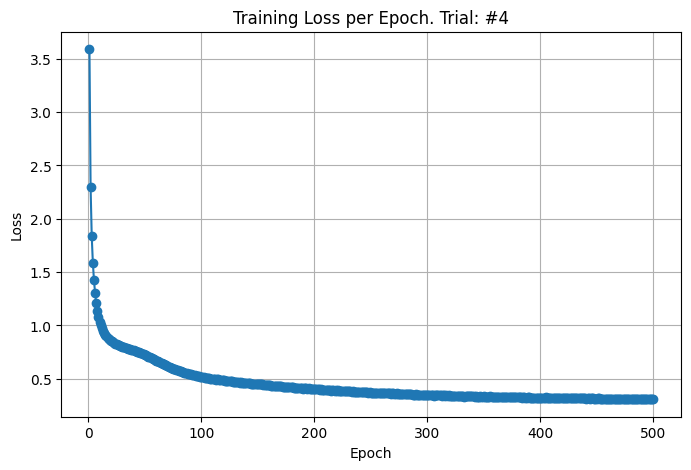


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb00000006000500270009

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 06ff00000003009002

✅ Byte-Level Accuracy: 95.00%
🧠 Byte-level Accuracy: 95.00%

🔁 Trial 5/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 2.0, 'lr': 0.0005, 'batch_size': 16.0, 'epochs': 50.0}
Epoch 1, Loss: 2.4010
Epoch 2, Loss: 1.2597
Epoch 3, Loss: 1.0123
Epoch 4, Loss: 0.9145
Epoch 5, Loss: 0.8659
Epoch 6, Loss: 0.8379
Epoch 7, Loss: 0.8160
Epoch 8, Los

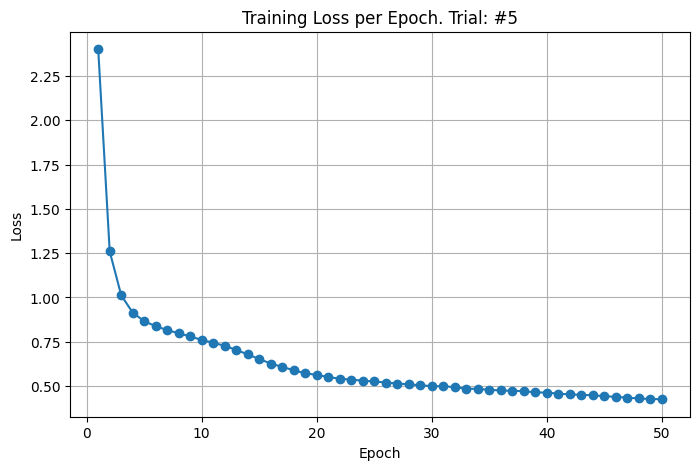


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb0000000600050005eb00

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 060800000003009002

✅ Byte-Level Accuracy: 94.40%
🧠 Byte-level Accuracy: 94.40%

🔁 Trial 6/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 2.0, 'lr': 0.0005, 'batch_size': 16.0, 'epochs': 100.0}
Epoch 1, Loss: 2.3695
Epoch 2, Loss: 1.2398
Epoch 3, Loss: 1.0007
Epoch 4, Loss: 0.9147
Epoch 5, Loss: 0.8711
Epoch 6, Loss: 0.8423
Epoch 7, Loss: 0.8218
Epoch 8, Lo

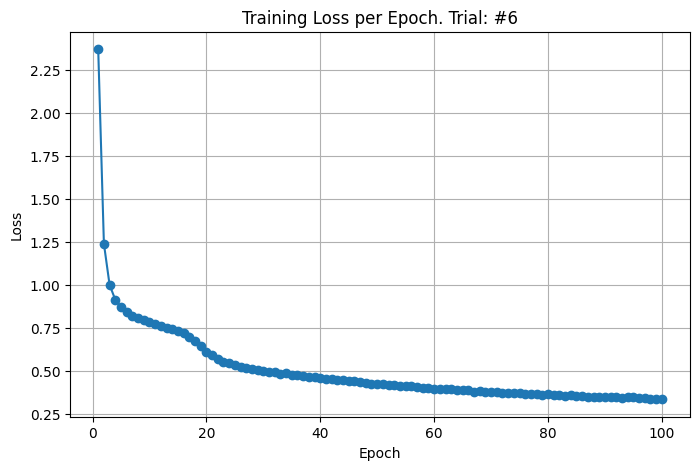


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb00000006000500000000

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 061000000003009002

✅ Byte-Level Accuracy: 95.60%
🧠 Byte-level Accuracy: 95.60%

🔁 Trial 7/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 2.0, 'lr': 0.0005, 'batch_size': 16.0, 'epochs': 250.0}
Epoch 1, Loss: 2.3795
Epoch 2, Loss: 1.2560
Epoch 3, Loss: 1.0029
Epoch 4, Loss: 0.9018
Epoch 5, Loss: 0.8593
Epoch 6, Loss: 0.8329
Epoch 7, Loss: 0.8108
Epoch 8, Lo

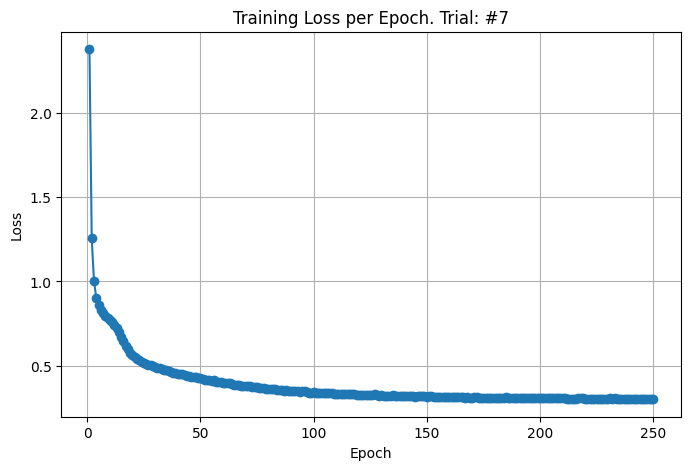


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb0000000600050003

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 06ff00000003009002

✅ Byte-Level Accuracy: 95.42%
🧠 Byte-level Accuracy: 95.42%

🔁 Trial 8/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 2.0, 'lr': 0.0005, 'batch_size': 16.0, 'epochs': 500.0}
Epoch 1, Loss: 2.3671
Epoch 2, Loss: 1.2698
Epoch 3, Loss: 1.0411
Epoch 4, Loss: 0.9281
Epoch 5, Loss: 0.8804
Epoch 6, Loss: 0.8497
Epoch 7, Loss: 0.8278
Epoch 8, Loss: 

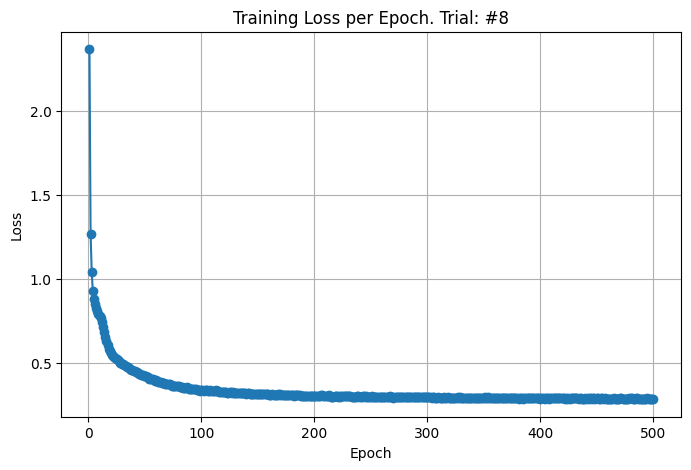


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb00000003008502

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 061000000003009002

✅ Byte-Level Accuracy: 95.66%
🧠 Byte-level Accuracy: 95.66%

🔁 Trial 9/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 4.0, 'lr': 0.0001, 'batch_size': 16.0, 'epochs': 50.0}
Epoch 1, Loss: 3.3229
Epoch 2, Loss: 2.0733
Epoch 3, Loss: 1.6378
Epoch 4, Loss: 1.4095
Epoch 5, Loss: 1.2682
Epoch 6, Loss: 1.1596
Epoch 7, Loss: 1.0778
Epoch 8, Loss: 1.0

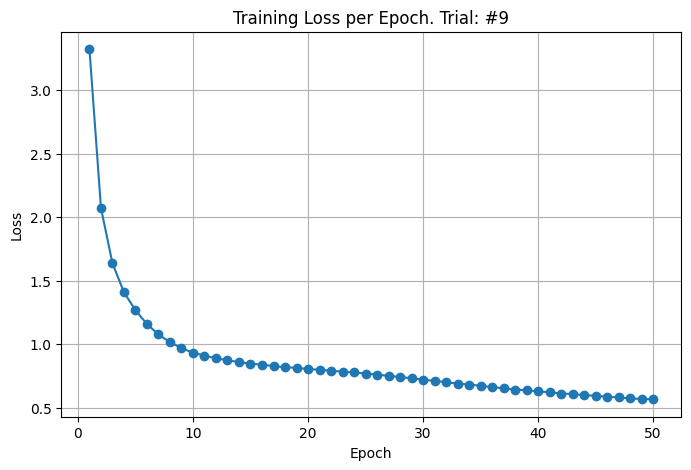


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb0000000600050027ff00

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 061000000003009002

✅ Byte-Level Accuracy: 94.94%
🧠 Byte-level Accuracy: 94.94%

🔁 Trial 10/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 4.0, 'lr': 0.0001, 'batch_size': 16.0, 'epochs': 100.0}
Epoch 1, Loss: 3.3414
Epoch 2, Loss: 2.0624
Epoch 3, Loss: 1.6296
Epoch 4, Loss: 1.3962
Epoch 5, Loss: 1.2399
Epoch 6, Loss: 1.1281
Epoch 7, Loss: 1.0485
Epoch 8, L

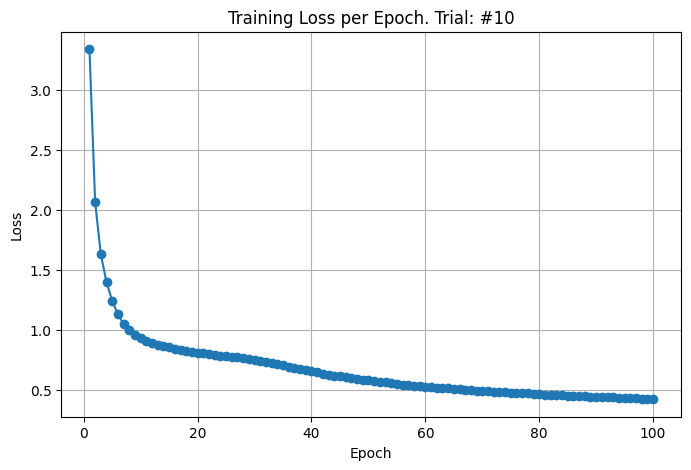


Query:              021d000000060003fffd0002
True Response:      021d00000003008302
Predicted Response: 021d00000003008302

Query:              012c000000060005fffdff00
True Response:      012c00000003008502
Predicted Response: 012c00000003008502

Query:              03eb00000006000500090000
True Response:      03eb00000006000500090000
Predicted Response: 03eb000000060005001b0000

Query:              045d000000060001fffe0001
True Response:      045d00000003008102
Predicted Response: 045d00000003008102

Query:              06100000000d001000280003060000ffff0000
True Response:      061000000003009002
Predicted Response: 061000000003009002

✅ Byte-Level Accuracy: 96.02%
🧠 Byte-level Accuracy: 96.02%

🔁 Trial 11/192 - Config: {'d_model': 128.0, 'n_heads': 2.0, 'n_layers': 4.0, 'lr': 0.0001, 'batch_size': 16.0, 'epochs': 250.0}
Epoch 1, Loss: 3.3454
Epoch 2, Loss: 2.0934
Epoch 3, Loss: 1.6564
Epoch 4, Loss: 1.4359
Epoch 5, Loss: 1.2880
Epoch 6, Loss: 1.1865
Epoch 7, Loss: 1.1064
Epoch 8, L

In [ ]:
#Grid search

import itertools
import pandas as pd
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

# Define the grid of values
param_grid = {
    "d_model": [128, 256],
    "n_heads": [2, 4, 8, 16],
    "n_layers": [2, 4, 8],
    "lr": [1e-4, 5e-4],
    "batch_size": [16],    # fixed
    "epochs": [50,100, 250, 500]        # fixed
}

#Best Combination found
# d_model          128.000000
# n_heads            4.000000
# n_layers           4.000000
# lr                 0.000500
# batch_size        16.000000
# epochs           500.000000
# byte_accuracy     96.566265
# Name: 39, dtype: float64

# Create all combinations of hyperparameters
grid = list(itertools.product(
    param_grid["d_model"],
    param_grid["n_heads"],
    param_grid["n_layers"],
    param_grid["lr"],
    param_grid["batch_size"],
    param_grid["epochs"]
))

# Convert to DataFrame for easier access
grid_df = pd.DataFrame(grid, columns=["d_model", "n_heads", "n_layers", "lr", "batch_size", "epochs"])

results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for idx, trial in grid_df.iterrows():
    print(f"\n🔁 Trial {idx+1}/{len(grid_df)} - Config: {trial.to_dict()}")

    # Build model
    model = DecoderOnlyTransformer(
        vocab_size=VOCAB_SIZE,
        d_model=int(trial["d_model"]),
        n_heads=int(trial["n_heads"]),
        n_layers=int(trial["n_layers"]),
        dropout=0.1
    ).to(device)

    # Prepare DataLoader
    loader = DataLoader(train_dataset, batch_size=int(trial["batch_size"]), shuffle=True, collate_fn=collate)

    # Training
    hparams = {
        "lr": trial["lr"],
        "epochs": int(trial["epochs"])
    }

    loss_history= train_transformer(model, loader, hparams, device)

        # Plotting
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
    plt.title(f"Training Loss per Epoch. Trial: #{idx+1}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


    # Evaluation
    acc = evaluate(model, test_dataset, device)
    print(f"🧠 Byte-level Accuracy: {acc:.2f}%")

    # Save results
    results.append({
        **trial.to_dict(),
        "byte_accuracy": acc
    })

# Optionally convert to DataFrame for analysis
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv("grid_search_results.csv", index=False)
print("\n✅ Grid search complete. Results saved to grid_search_results.csv.")



In [ ]:
best_trial = results_df.sort_values(by="byte_accuracy", ascending=False).iloc[0]
print("🏆 Best Hyperparameter Configuration:")
print(best_trial)

In [11]:
import csv
import pandas as pd

# Open the CSV file in read mode ('r') with newline=''
# The newline='' argument is crucial to prevent extra blank rows
# when reading on some operating systems.

df = pd.read_csv('grid_search_results.csv')

best_trial = df.sort_values(by="byte_accuracy", ascending=False).iloc[0:10]
print("🏆 Best Hyperparameter Configuration:")
print(best_trial)

🏆 Best Hyperparameter Configuration:
     d_model  n_heads  n_layers      lr  batch_size  epochs  byte_accuracy
39     128.0      4.0       4.0  0.0005        16.0   500.0      96.566265
10     128.0      2.0       4.0  0.0001        16.0   250.0      96.445783
45     128.0      4.0       8.0  0.0005        16.0   100.0      96.445783
52     128.0      8.0       2.0  0.0005        16.0    50.0      96.445783
156    256.0      8.0       4.0  0.0005        16.0    50.0      96.445783
162    256.0      8.0       8.0  0.0001        16.0   250.0      96.385542
163    256.0      8.0       8.0  0.0001        16.0   500.0      96.325301
92     128.0     16.0       8.0  0.0005        16.0    50.0      96.325301
84     128.0     16.0       4.0  0.0005        16.0    50.0      96.265060
152    256.0      8.0       4.0  0.0001        16.0    50.0      96.265060


In [ ]:
#Best Combination found
# d_model          128.000000
# n_heads            4.000000
# n_layers           4.000000
# lr                 0.000500
# batch_size        16.000000
# epochs           500.000000
# byte_accuracy     96.566265
# Name: 39, dtype: float64